In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Attention
from keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import keras.backend as K

In [2]:
def get_data_frame():
    current_folder = os.getcwd()
    file_path = os.path.join(current_folder,'..' ,'resource', 'RSMC_Best_Track_Data.csv')
    df = pd.read_csv(file_path)

    # ---------------------------

    direction_30_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 6, 'Southwest (SW)': 8}
    df['Direction of the longest radius of 30kt winds or greater'] = df[
        'Direction of the longest radius of 30kt winds or greater'].map(direction_30_mapping)

    direction_50_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 6, 'Southwest (SW)': 8,
                            'No direction (Longest radius of 50kt winds is 0)': 9}
    df['Direction of the longest radius of 50kt winds or greater'] = df[
        'Direction of the longest radius of 50kt winds or greater'].map(direction_50_mapping)

    indicator_mapping = {'#': 1, ' ': 0}
    df['Indicator of landfall or passage'] = df['Indicator of landfall or passage'].map(indicator_mapping)

    # ----------------------

    df = df.drop(['International number ID', 'Name of the storm', 'Grade'], axis=1)
    columns_to_check = [
        'Direction of the longest radius of 50kt winds or greater',
        'The longest radius of 50kt winds or greater',
        'The shortest radius of 50kt winds or greater',
        'Direction of the longest radius of 30kt winds or greater',
        'The longest radius of 30kt winds or greater',
        'The shortest radius of 30kt winds or greater'
    ]
    df = df.dropna(subset=columns_to_check)

    # -----------------------

    one_hot_encoded = pd.get_dummies(df['Direction of the longest radius of 50kt winds or greater'],
                                     prefix='Direction of the longest radius of 50kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded], axis=1)

    one_hot_encoded2 = pd.get_dummies(df['Direction of the longest radius of 30kt winds or greater'],
                                      prefix='Direction of the longest radius of 30kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded2], axis=1)
    df = df.drop(['Direction of the longest radius of 50kt winds or greater',
                  'Direction of the longest radius of 30kt winds or greater'], axis=1)

    # ----------------------

    df['Time of analysis'] = pd.to_datetime(df['Time of analysis'])
    df['Time of analysis'] = df['Time of analysis'].apply(lambda x: x.timestamp())

    # -----------------------
    return df

def min_max_scaler(df):
    
    
    columns_to_normalize = df.columns[:]

    # 实例化 MinMaxScaler
    scaler = MinMaxScaler()

    # 对选择的列进行归一化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # 打印处理后的新 DataFrame 的信息
    #df.tail()

    return df

def split_data(df):

    split_index = int(0.7 * len(df))

    # 分割DataFrame
    train_set = df.iloc[:split_index, :]
    test_set = df.iloc[split_index:, :]

    train_x = train_set.drop(["Latitude of the center", "Longitude of the center"], axis=1)
    train_y = train_set.loc[:, ["Latitude of the center", "Longitude of the center"]]
    test_x = test_set.drop(["Latitude of the center", "Longitude of the center"], axis=1)
    test_y = test_set.loc[:, ["Latitude of the center", "Longitude of the center"]]
    # 给训练集的标签打上时间序列
    first_column = train_x.iloc[:, 0]
    train_y.insert(0, 'Time of analysis', first_column)
    

    return train_x, train_y, test_x, test_y

df = get_data_frame()
df_min_max = min_max_scaler(df)
x_train, y_train, text_x, test_y = split_data(df_min_max)



In [3]:
test_head_y = test_y.loc[text_x.index[-20:-15]]

test_head_x = text_x.loc[text_x.index[-20:-15]]

test_tail_y = test_y.loc[text_x.index[-15:]]

test_tail_x = text_x.loc[text_x.index[-15:]]

In [4]:
@keras.saving.register_keras_serializable()
def haversine_loss(y_true, y_pred):
    lat_true, lon_true = y_true[:, 1], y_true[:, 2]
    lat_pred, lon_pred = y_pred[:, 0], y_pred[:, 1]

    # 将度转换为弧度
    pi = tf.constant(np.pi)
    lat_true, lon_true, lat_pred, lon_pred = [x * (pi / 180) for x in [lat_true, lon_true, lat_pred, lon_pred]]

    dlat = lat_pred - lat_true
    dlon = lon_pred - lon_true

    a = tf.sin(dlat / 2)**2 + tf.cos(lat_true) * tf.cos(lat_pred) * tf.sin(dlon / 2)**2
    c = 2 * tf.asin(tf.sqrt(a))

    # 地球平均半径，单位公里
    R = 6371.0
    return R * c

In [5]:
early_stopper = EarlyStopping(
    monitor='val_loss',  # 监控验证损失
    patience=20,         # 在10个epoch内如果没有改善则停止
    verbose=1,           # 打印早停日志
    mode='min',          # 监控的指标是需要最小化的
    restore_best_weights=True  # 恢复到最佳模型权重
)

In [6]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# 创建回调函数
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [6]:
n_features_x, n_outputs_x = x_train.shape[1], y_train.shape[1]
n_features_y = y_train.shape[1]
y_train_reshaped = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))

In [7]:
print(f"n_features_x: {n_features_x}")
print(f"n_output_x: {n_outputs_x}")

n_features_x: 24
n_output_x: 3


In [20]:
verbose, epochs, batch_size = 1, 100, 160

# Assuming x_train and y_train have shapes: (samples, features) for both x_train and y_train
n_features_x, n_outputs_x = x_train.shape[1], y_train.shape[1]
n_features_y = y_train.shape[1]

# reshape output into [samples, features]
y_train_reshaped = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features_x, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs_x))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss=haversine_loss, optimizer='adam')

history = model.fit(x_train.values, y_train_reshaped, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=verbose, 
                    validation_split=0.0005,
                    callbacks=[early_stopper, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
120/120 [==============================] - 6s 25ms/step - loss: 25.1735 - val_loss: 12.6391 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
120/120 [==============================] - 2s 21ms/step - loss: 21.9704 - val_loss: 13.7524 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
120/120 [==============================] - 3s 22ms/step - loss: 21.8299 - val_loss: 11.8156 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
120/120 [==============================] - 3s 21ms/step - loss: 21.7666 - val_loss: 11.5687 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
120/120 [==============================] - 2s 21ms/step - loss: 21.6996 - val_loss: 9.6991 - lr: 0.0010

Epoch 6: Learni

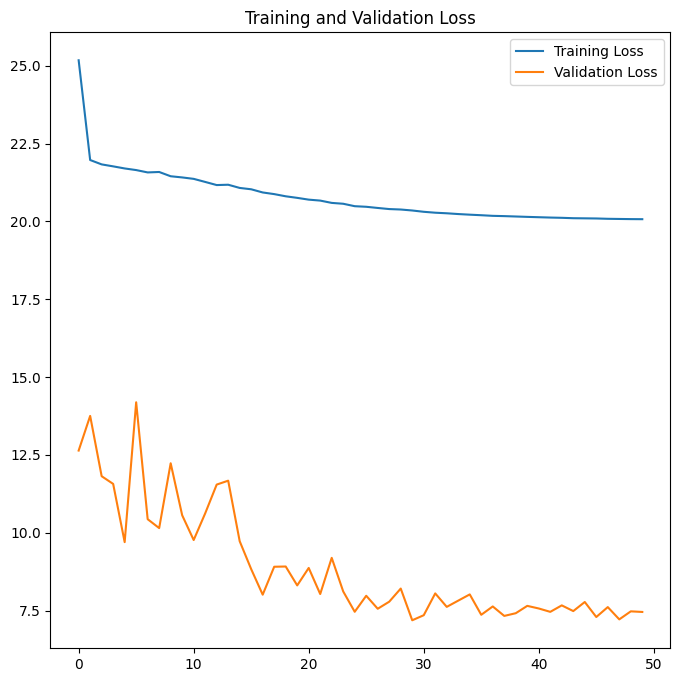

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))  # Set the range based on the actual number of epochs trained

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 323ms/step


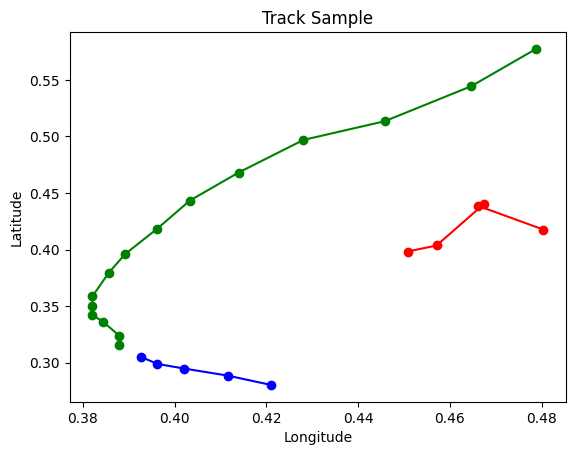

In [22]:
testPredict = model.predict(test_head_x)

#test_head
plt.plot(test_head_y['Longitude of the center'], test_head_y['Latitude of the center'], color='blue', marker='o')
#test_tail
plt.plot(test_tail_y['Longitude of the center'], test_tail_y['Latitude of the center'], color = 'green', marker='o')
#predict
plt.plot(testPredict[:, 2], testPredict[:, 1], label='numpy_array', color='red', marker='o')



# 设置图表标题和轴标签
plt.title('Track Sample')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示图表
plt.show()

In [18]:
model.save(r'C:\CODE\tropical_cyclone_prediction\model\CNN-LSTM-EXP10.keras')